Notebook updated on 2025.09.30 and compatible with latest github revisions from that date.

# Imports

## General imports

In [1]:
import os
from matplotlib import pyplot as plt
import numpy as np
import pickle
from importlib import reload
import copy
import time
from scipy.optimize import leastsq

## Specialized imports

In [2]:
from common.baseclasses import AWA # https://github.com/asmcleod/common.git
from common.misc import flatten
from NearFieldOptics import Materials as M # https://github.com/asmcleod/NearFieldOptics.git
from mnOPSuite.PRISM.python import scandelay_FTIR as sd # https://github.com/mnop-laboratory/mnOPSuite.git

<material_types.TabulatedMaterialFromFile.__init__>:
	Loading tabulated material data from file "Bi2Se3_epsilon.pickle"...
<material_types.TabulatedMaterialFromFile.__init__>:
	Loading tabulated material data from file "PMMA_epsilon.pickle"...
<material_types.TabulatedMaterialFromFile.__init__>:
	Loading tabulated material data from file "sio2_300nm_extracted_epsilon_cone_A=2a.pickle"...
<material_types.TabulatedMaterialFromFile.__init__>:
	Loading tabulated material data from file "TaS2_eps_230K.csv"...
<material_types.TabulatedMaterialFromFile.__init__>:
	Loading tabulated material data from file "TaS2_eps_30K.csv"...
<material_types.TabulatedMaterialFromFile.__init__>:
	Loading tabulated material data from file "Erik_BSTS_epsilon.pickle"...
<material_types.TabulatedMaterialFromFile.__init__>:
	Loading tabulated material data from file "VO2_295K.csv"...
<material_types.TabulatedMaterialFromFile.__init__>:
	Loading tabulated material data from file "VO2_360K.csv"...
<material_types.Ta

## Tools for inversion

In [3]:
import ProbeCavityEigenfields as PCE # https://github.com/asmcleod/ProbeCavityEigenfields.git
from ProbeCavityEigenfields import RotationalMoM as RotMOM
from ProbeCavityEigenfields import ProbeSpectroscopy as PS
from ProbeCavityEigenfields import EigenInversion as EI 

<plotting>:
	Registered colormaps "Warm" and "Warm_r"...
<plotting>:
	Registered colormaps "vanheum" and "vanheum_r"...
<plotting>:
	Registered colormaps "NT-MDT" and "NT-MDT_r"...
<plotting>:
<plotting>:
	Registered colormaps "jingdi" and "jingdi_r"...
<plotting>:
	Registered colormaps "Halcyon" and "Halcyon_r"...
<plotting>:
	Registered colormaps "Cold" and "Cold_r"...
<plotting>:
	Registered colormaps "Sky" and "Sky_r"...
<plotting>:
	Registered colormaps "Gwyddion.net" and "Gwyddion.net_r"...
<plotting>:
	Registered colormaps "BlueRed" and "BlueRed_r"...
<plotting>:
	Registered colormaps "vanheum3" and "vanheum3_r"...
<plotting>:
	Registered colormaps "vanheum2" and "vanheum2_r"...


# Load processed spectroscopy data

In [4]:
linescan_name = 'Try2/S3_WNbS2@15pct_30pts_13333nm-5000nm'

In [5]:
load_filename = os.path.basename(linescan_name)+'_ProcessedSpectra.pickle'

with open(load_filename,'rb') as f:
    loaded_data = pickle.load(f)
    print('File "%s" successfully loaded!'%load_filename)

target_materials = loaded_data['target_materials']
spectra_norm = loaded_data['spectra_norm']
spectra_std_norm = loaded_data['spectra_std_norm']

File "S3_WNbS2@15pct_30pts_13333nm-5000nm_ProcessedSpectra.pickle" successfully loaded!


Text(0, 0.5, 'Angle(S) [rad.]')

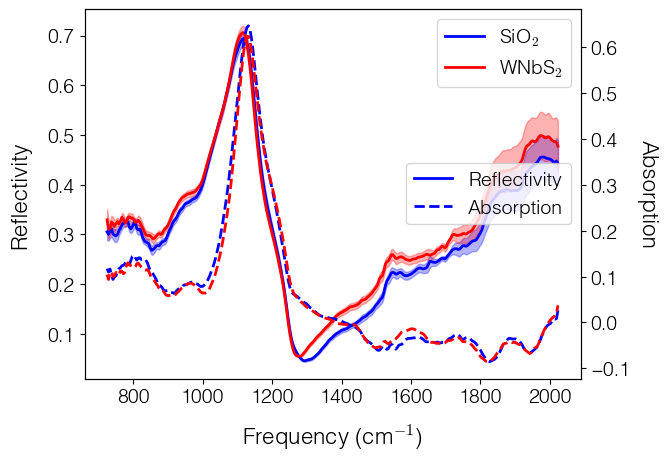

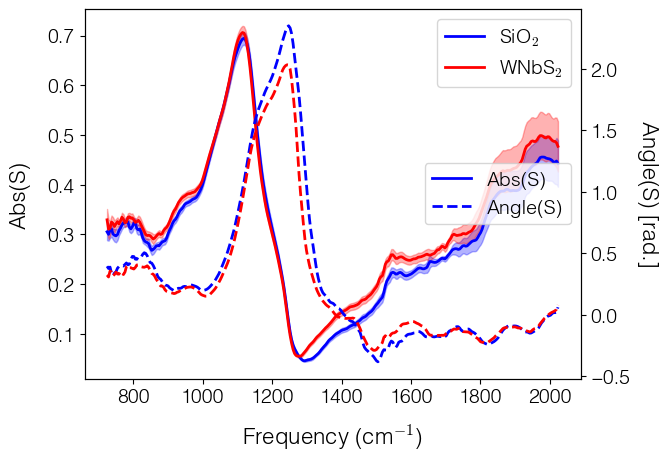

In [6]:
f1=plt.figure()
ax11=plt.gca()
ax12=plt.twinx()

f2=plt.figure()
ax21=plt.gca()
ax22=plt.twinx()

from common.plotting import bluered_colors
cs = bluered_colors(len(target_materials))

ls_mat={}
ls_descrip1={}
ls_descrip2={}
for i,mat in enumerate(target_materials):

    S = spectra_norm[mat]
    std = spectra_std_norm[mat]
    c=next(cs)

    plt.sca(ax11)
    l1,=np.abs(S).plot(color=c)
    plt.fill_between(S.axes[0],np.abs(S)+std/2,np.abs(S)-std/2,color=c,alpha=.3)
    plt.sca(ax12)
    l2,=np.imag(S).plot(color=c,ls='--')

    ls_mat[mat]=l1
    if i==0:
        ls_descrip1['Reflectivity'] = l1
        ls_descrip1['Absorption'] = l2
    
    plt.sca(ax21)
    l1,=np.abs(S).plot(color=c)
    plt.fill_between(S.axes[0],np.abs(S)+std/2,np.abs(S)-std/2,color=c,alpha=.3)
    plt.sca(ax22)
    l2,=plt.plot(S.axes[0],np.unwrap(np.angle(S)),
             color=c,ls='--')

    ls_mat[mat]=l1
    if i==0:
        ls_descrip2['Abs(S)'] = l1
        ls_descrip2['Angle(S)'] = l2
    
plt.sca(ax11)
plt.legend(ls_mat.values(),ls_mat.keys(),loc='upper right')
plt.ylabel('Reflectivity')
plt.xlabel('Frequency (cm$^{-1}$)')
plt.sca(ax12)
plt.legend(ls_descrip1.values(),ls_descrip1.keys(),loc='center right')
plt.ylabel('Absorption',rotation=270,labelpad=20)

plt.sca(ax21)
plt.legend(ls_mat.values(),ls_mat.keys(),loc='upper right')
plt.ylabel('Abs(S)')
plt.xlabel('Frequency (cm$^{-1}$)')
plt.sca(ax22)
plt.legend(ls_descrip2.values(),ls_descrip2.keys(),loc='center right')
plt.ylabel('Angle(S) [rad.]',rotation=270,labelpad=20)

    

## Examine spectra of 2D material relative to substrate

(-0.2, 0.2)

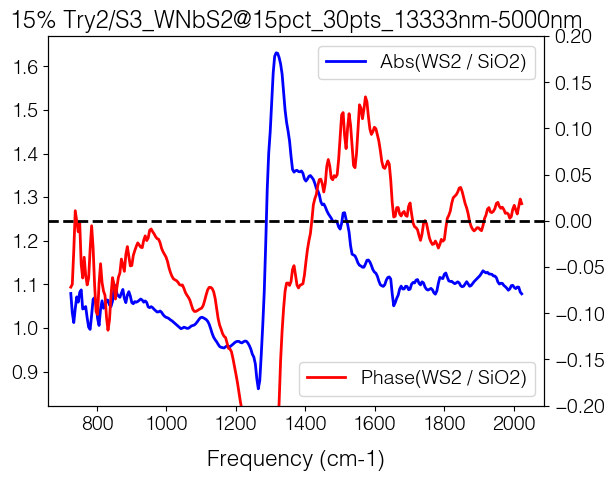

In [10]:
sio2,wns2 = target_materials
s = spectra_norm[wns2]/spectra_norm[sio2]
np.abs(s).plot(color='b',label='Abs(WS2 / SiO2)')
plt.legend(loc='upper right')
plt.twinx()
plt.plot(s.axes[0], np.angle(s), color='r',label='Phase(WS2 / SiO2)')
plt.legend(loc='lower right')
plt.axhline(0,ls='--',color='k')
plt.title('15% '+linescan_name)
plt.ylim(-.2,.2)

## Build target spectra: apply corrections and down-sample

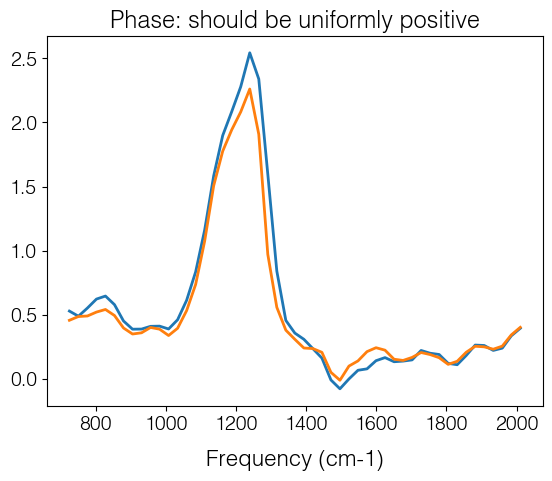

In [11]:

target_spectra = {}
target_spectra_std = {}
target_phase_corrections = {}

downsampling=6
for i,mat in enumerate(target_materials):

    # down-sample
    s=spectra_norm[mat].copy()[::downsampling]
    std = spectra_std_norm[mat].copy()[::downsampling]
    
    if i==0:
        target_fs = s.axes[0]
    # Phase correction
    # We don't want measured phase to be less than zero if gold is reference.
    # If phase is less than zero, it may be because of topography, so fix it.
    phase_factor = 1
    height= 300e-7 # relative to ref material, in cm (sio2 relative to Au)
        
    target_phase_correction = np.exp(1j*2*np.pi * target_fs * phase_factor * height)

    # amplitude correction, in case we need it
    #s *= 0.8/0.6    
    s *= target_phase_correction

    plt.title('Phase: should be uniformly positive')
    np.arctan2(s.imag,s.real).plot()

    target_spectra[mat] = s
    target_spectra_std[mat] = std
    target_phase_corrections[mat] = target_phase_correction


# Predict plasma frequency for Nb-WS2

In [12]:
#--- Symbols will be: ----
# c = speed of light
# e = electron charge
# meff = effective mass (of electron) in nanowire
# wp = plasma frequency in nanowire
# wlmeas = laser wavelength where we do measurement
# nwire = carrier density in the nanowrie
# Vg = gate voltage
# dwire = nanowire diameter
# Lwire = length of nanowire
# epsg = permittivity of gate dielectric
# epswire = high frequency permittivity of nanowire (InSb)
import sympy as sp
c,e,meff,wp,wmeas,wlmeas,nwire,Vg,dwire,Lwire,h,epsg,epswire = sp.symbols(r'c e m_{eff} \omega_p \omega_{meas} \lambda_{meas} n_w V_g d_w L_w h \varepsilon_g \varepsilon_w')

#--- Numeric values to plug in later when ready ---
# All units will be gaussian (this is cgs units with charges in statC, voltages in statV, etc)
c_val = 3e10 # speed of light in cm/s
me_val = 9e-31*1000 # electron mass in g
e_val = 4.8e-10 # electron charge in statC (cgs)

epswire_val = 5 #high-frequency permittivity of nanowire material
meff_val = 0.6*me_val # effective mass for WS2
nwire_val = 8e19 # carrier density in 1/cm^3

#vacuumperm_val = 8.85e-12 #@ALEX: units are not specified, but anyway in cgs (gaussian) units eps0 does not appear in equations of electromagnetism (equivalently, eps0 = 1)

In [13]:
wp = sp.sqrt(4*sp.pi*nwire*e**2/(meff*epswire_val))
print('Fromula for predicted plasma frequency (cgs units)')
display(wp)

subs={meff:meff_val,epswire:epswire_val,e:e_val,c:c_val,nwire:nwire_val}
wp_val = wp.subs(subs)
wp_val_wn = wp_val/c_val/(2*np.pi)

print('Predicted plasma frequency (numerical, cgs units, radians*Hz)')
print('%1.2G'%wp_val)

print('Predicted plasma frequency (numerical, cgs units, cm^-1)')
print('%1.2G'%wp_val_wn)




Fromula for predicted plasma frequency (cgs units)


2*sqrt(5)*sqrt(pi)*sqrt(e**2*n_w/m_{eff})/5

Predicted plasma frequency (numerical, cgs units, radians*Hz)
2.9E+14
Predicted plasma frequency (numerical, cgs units, cm^-1)
1.6E+03


# Inversion

This tool is optimized to quickly simulate near-field signal at light frequency $\omega$ from a 2D material of conductivity $\sigma_{2D}(\omega)$ sitting atop a substrate material with permittivity $\epsilon_\mathrm{subs}(\omega)$.  In practice, throughout this business the optical conductivity $\sigma_{2D}$ is re-parametrized into a more convenient measure called the "plasmon wavevector" $q_p$ which is defined as:

$q_p(\omega)=i\omega/(2\pi\sigma_{2D}(\omega))$

This is not the only relation betwen $q_p$ and optical properties of a thin material.  If we consider $\sigma_{2D}=\sigma_{3D} \cdot t$ as the 2D (sheet) conductivity associated with a thin material of bulk conductivity $\sigma_{3D}$ (we may drop the subscript "3D") and thickness $t$, then we can use the relation $\epsilon(\omega)=1+4\pi i \sigma(\omega)/\omega$ to relate $q_p$ to $\epsilon$, the (bulk) permittivity of the thin material:

$\sigma_{2D} = \frac{i\omega}{4\pi} (1-\epsilon), \quad$    thus:    $\quad q_p(\omega)\,t =2/(1-\epsilon) \quad$    and:    $\quad \epsilon-1 = -1/(q_p(\omega)\,t)$.

In terms of this wavevector value, the near-field reflectivity (Fresnel coefficient $r_p$) of the 2D material atop the substrate is given as function of illumination wave-vector $q$ by:

$r_p(q,\omega) = (\beta \cdot q_{p,scr} - q)/(q_{p,scr}-q)$.

Here $\beta(\omega)\equiv (\epsilon_\mathrm{subs}(\omega)-1)/(\epsilon_\mathrm{subs}(\omega)+1)$ describes the reflectivity of the substrate even if no 2D material were present (in which case $q_p\rightarrow\infty$), and $q_{p,scr}$ is the screened plasmon wavevector given by $q_{p,scr}(\omega)=q_p(\omega) \cdot (\epsilon_\mathrm{subs}(\omega)+1)/2$.

In truth, with an optical probe of typical tip radius $a$, the strength of optical interaction between the probe and the 2D material will be controlled by the dimensionless product $q_p \cdot a$.  This can be seen by the fact that such a probe may illuminate the 2D material with light fields of characteristic momentum $q^*\sim 1/a$.

Thus, calculations are all performed by providing the dimensionless value of $\bar{q}_p \equiv q_p\cdot a$ in lieu of the dimensionful plasmon wavevector, and also any extraction of $q_p$ with this tool will also measure the plasmon wavevector in units of $q^*$.  Namely, extraction can return the following value:

$\bar{q}_p \equiv q_p/q^* = q_p\cdot a =q_p\,t \cdot a/t =2/(1-\epsilon)\cdot a/t$.

Reversing the relation, note that $\epsilon$ might be obtained from $\bar{q}_p$ as:

$\epsilon = 1-2 a/(\bar{q}_p\,t) $.

* Fitting of the 2D material response is actually done by expanding the "dimensionless excess permittivity" $= -1/\bar{q}_p$ as a series of Kramers-Kronig compatible oscillators (like Lorentzians).  Their dimensionless amplitudes should be multiplied by $q^* \cdot a = a/t$ to regain an actual permittivity for the 2D material.

* Fitting of the substrate response is done likewise by expanding $\epsilon_\mathrm{subs}(\omega)$ as a series of Kramers-Kronig compatible oscillators (like Lorentzians).

## Build predictor and material model

In [14]:
# Pickle files associated with probe "Hyperboloid=20nm_L=23microns_Nnodes=488" or "hyperboloid" should be distributed with this notebook
# But other probes can be used or generated.
# Scroll to section "Optional: Prepare and evaluate Predictor from scratch" to turn a new probe into a Predictor.

#probe_name = 'Cone_a=20nm_taper=21_L=23microns_Nnodes=244' # This model is very fine-tuned, and has cgs units (probe radius = 20e-7 cm)
reload(PS)
probe_name = 'Hyperboloid_a=20nm_taper=21_L=23microns_Nnodes=244'
ProbeEncoded = PCE.load(probe_name,PS.EncodedEigenfields)
P = ProbeEncoded.get_probe()

# Set up our predictor
# We will take reference signal for material with high permittivity (gold)
# zmin = minimum approach distance (rel. tip radius) of probe to sample (don't make it too small, we'll have an error)
# A = amplitude of tapping (rel. tip radius)
# Nts = number of time points in the tapping to include in the simulation
# harmonic = e.g. 3 for simulating 3rd harmonic data
# qp_ref = the qp value (rel. tip radius) of the 2D material in the normalization material (make ~infinity to deactivate 2D material)
# eps_ref = the permittivity of the substrate in the normalization material (make ~infinity to resemble a good metal like gold)
a = ProbeEncoded.get_probe().get_a() # tip radius
reload(EI)
Predictor = EI.EncodedEigenfieldsPredictor(ProbeEncoded,
                                           zmin=a/10, A=4*a, Nts=24,
                                            harmonic=3,
                                            qp_ref=1e8/a,
                                            eps_ref=1e8,
                                           Nmodes=15) # More eigenmodes, more accuracy, more expense!

Attemping to load from file "/Users/alexandersmcleod/tools/python/ProbeCavityEigenfields/Probe models/(Hyperboloid_a=20nm_taper=21_L=23microns_Nnodes=244)_EncodedEigenfields.pickle"...
<ProbeCavityEigenfields._ProbesCollection.__setitem__>:
	Registering probe "Hyperboloid_a=20nm_taper=21_L=23microns_Nnodes=244"...
Successfully loaded from file "/Users/alexandersmcleod/tools/python/ProbeCavityEigenfields/Probe models/(Hyperboloid_a=20nm_taper=21_L=23microns_Nnodes=244)_EncodedEigenfields.pickle"!


In [15]:
MaterialModel = EI.VariationalMaterial2D(Predictor, target_fs,
                                     Nosc_eps=4, amp_eps=0,
                                     Nosc_qp=3, amp_qp=0)

MaterialModel.interrupt_error = False # With this setting, keyboard interrupt will not raise an error but will simply terminate fitting

material_params = {} # Store material parameters at different stages as we go along

## Optimize Eps for substrate

### Point-by-point fit for substrate to help shepherd MaterialModel

Elapsed: 0.072390794754028320


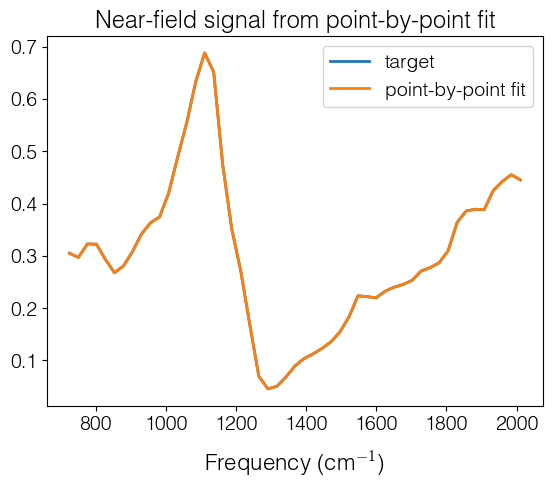

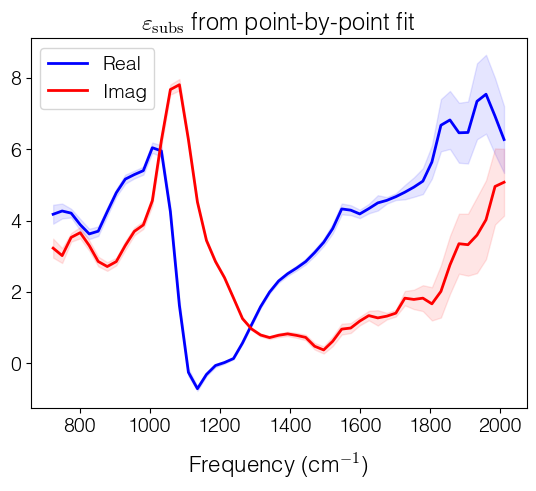

In [16]:
# Perform point-by-point fit of substrate permittivity

S_targets = target_spectra[sio2]
S_targets_std = target_spectra_std[sio2]

eps_guess = 3+1j # @UPDATE: use whatever guesss for initial permittivity
PbP_eps_result = EI.Fit_eps_PointByPoint(S_targets,target_fs,
                                         Predictor,eps_guess=eps_guess,
                                        S_targets_uncertainty = S_targets_std)

Residual before fitting: 557.0413438482966
Elapsed: 0.190
Residual after fitting: 13.748910942685526
Residual before fitting: 23.036520095653067
Elapsed: 0.110
Residual after fitting: 21.804487812748658


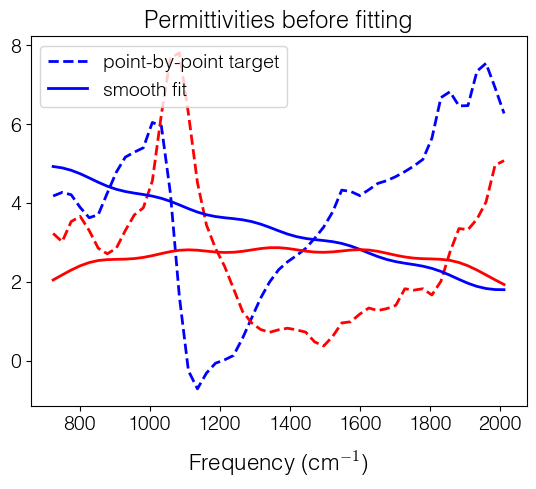

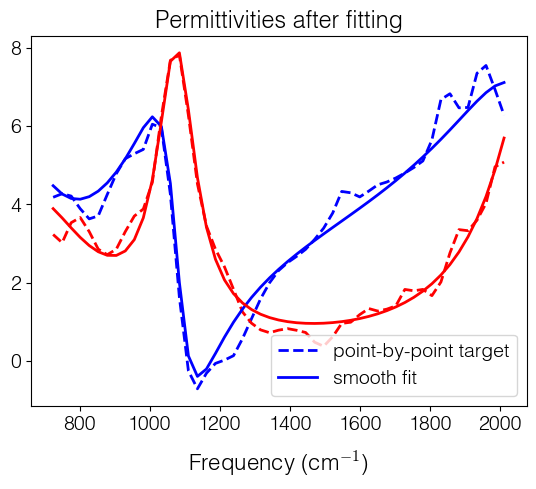

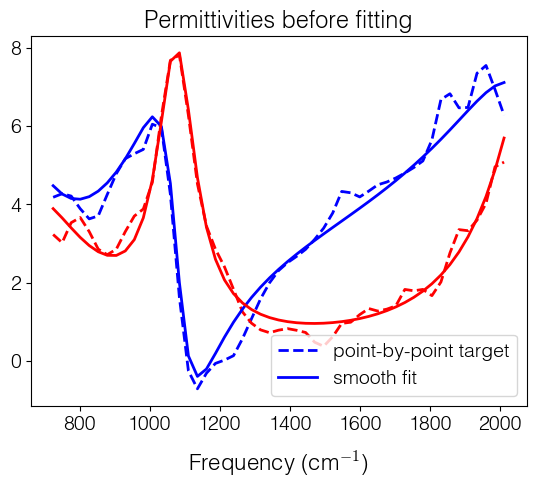

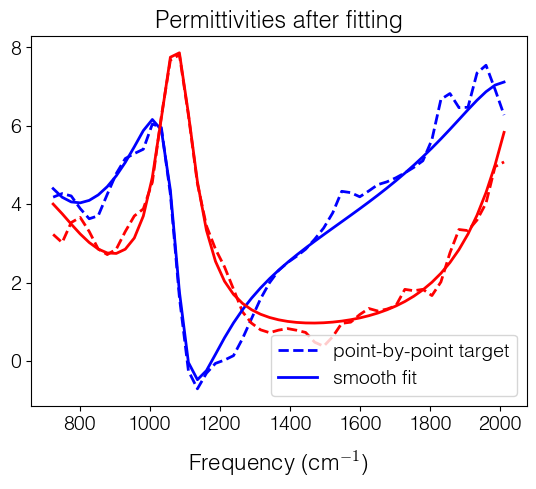

In [17]:
# Find a set of oscillators that best-match the point-by-point permittivity

leastsq_kwargs = dict(factor=.1,maxfev=1000,ftol=1e-12,xtol=1e-12) # @UPDATE: change parameters to make leastsq do its job
smooth_fit_kwargs = dict(Nosc=5,amp=1,eps0=3+1j) #@UPDATE: Use the minimum necessary number of oscillators, and a permittivity offset
kwargs=copy.copy(leastsq_kwargs)
kwargs.update(smooth_fit_kwargs)

reset_MaterialModel=True
for exp in [2,1]: # Can loop over several error exponents to make fit better and better
    eps_smooth = EI.FitPbP_eps_to_oscillators(eps_target=PbP_eps_result['eps_predicted'],
                                              target_fs=target_fs,
                                                 MaterialModel=MaterialModel,
                                                 reset_MaterialModel=reset_MaterialModel,
                                                 exp=exp,
                                                 **kwargs)
    reset_MaterialModel=False


### Global refinement using coarse parameters

Supercycle #1..
Optimizing "eps_coarse" in cycle #1...
Optimizing "eps_coarse" in subcycle #1, exp=0.50...
R=7.47; time elapsed (s) in cycle: 45.65
Optimizing "eps_coarse" in subcycle #2, exp=2.00...
R=7.47; time elapsed (s) in cycle: 47.09
Exit criterion 0.001 satisfied...
Time elapsed (s) for optimization: 92.7427430152893
Optimizing "eps_fine" in cycle #1...
Optimizing "eps_fine" in subcycle #1, exp=0.50...
R=4.91; time elapsed (s) in cycle: 53.43
Optimizing "eps_fine" in subcycle #2, exp=2.00...
R=4.66; time elapsed (s) in cycle: 50.61
Optimizing "eps_fine" in cycle #2...
Optimizing "eps_fine" in subcycle #1, exp=0.50...
R=4.57; time elapsed (s) in cycle: 49.41
Optimizing "eps_fine" in subcycle #2, exp=2.00...
R=4.53; time elapsed (s) in cycle: 50.10
Time elapsed (s) for optimization: 203.55598497390747


Text(0.5, 0, 'Energy')

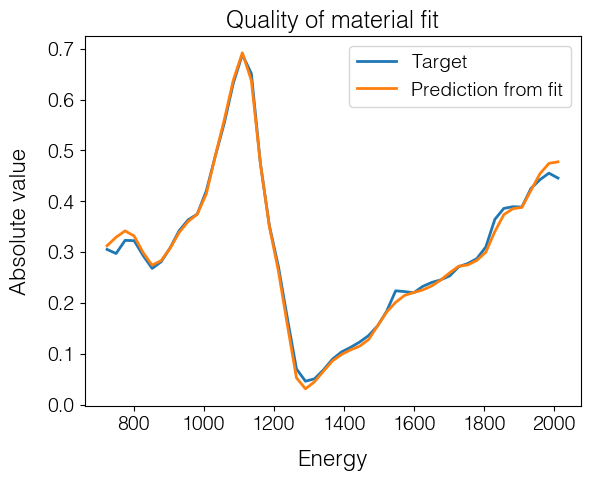

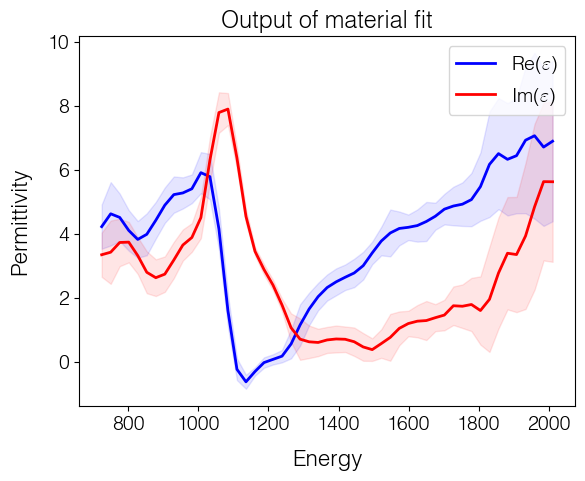

In [18]:
#------ Choose substrate as the target
S_targets = target_spectra[sio2]
S_targets_std = target_spectra_std[sio2]
MaterialModel.additional_normalization = None

#----- Run the optimization
#@UPDATE: all these parameters are variable
Nsupercycles=1 # Make this nonzero to actually run cycles of optimization, otherwise just plot the prediction
r=0 # If nonzero (e.g. 1e-2), slightly randomizes parameters between cycles, helps to fitting routine jump out of local minima
optimize_coarse = True
optimize_fine = True
leastsq_kwargs = dict(factor=100,maxfev=200,xtol=1e-8,ftol=1e-8)

MaterialModel.unfix_epss()
for i in range(Nsupercycles):
    print('Supercycle #%i..'%(i+1))
    
    if optimize_coarse:
        MaterialModel.optimize_eps_coarse(S_targets,S_targets_std,
                                         exp_start=0.5,exp_stop=2,
                                         Nsubcycles=2,Ncycles=2,
                                          randomization=r,
                                         **leastsq_kwargs)

    if optimize_fine:
        MaterialModel.optimize_eps_fine(S_targets,S_targets_std,
                                         exp_start=0.5,exp_stop=2,
                                         Nsubcycles=2,Ncycles=2,
                                          randomization=r,
                                         **leastsq_kwargs)

#--- Predict spectrum

S_SiO2_pred = MaterialModel.predict(qps_enabled=False)

plt.figure()
plt.title('Quality of material fit')
plt.plot(target_fs,np.abs(S_targets),label='Target')
plt.plot(target_fs,np.abs(S_SiO2_pred),label='Prediction from fit')
plt.legend()
plt.ylabel('Absolute value')
plt.xlabel('Energy')

#---- Predict optimized permittivity of substrate and estimated error in fit

experimental_uncertainty = 0.02 # Add an additional relative uncertainty on top of that derived from standard deviation
fit_uncertainty = np.abs(S_SiO2_pred-S_targets)
pred_dev = fit_uncertainty + experimental_uncertainty
error = np.sqrt(pred_dev**2+S_targets_std**2)
deps,dqp = MaterialModel.estimate_error(error,offset=.01)

plt.figure()
eps = MaterialModel.get_epss()
plt.title('Output of material fit')
plt.plot(MaterialModel.freqs,eps.real,label=r'Re($\varepsilon$)',color='b')
plt.fill_between(MaterialModel.freqs,eps.real+deps,eps.real-deps,color='b',alpha=.1)
plt.plot(MaterialModel.freqs,eps.imag,label=r'Im($\varepsilon$)',color='r')
plt.fill_between(MaterialModel.freqs,eps.imag+deps,eps.imag-deps,color='r',alpha=.1)
plt.legend()
plt.ylabel('Permittivity')
plt.xlabel('Energy')

### Store MaterialModel parameters

In [19]:
material_params = MaterialModel.get_params()

### Load MaterialModel parameters

In [20]:
MaterialModel.set_params(material_params)

## Optimize qp for 2D material

### Point-by-point fit for 2D material to help shepherd MaterialModel

Elapsed: 15.62237167358398484


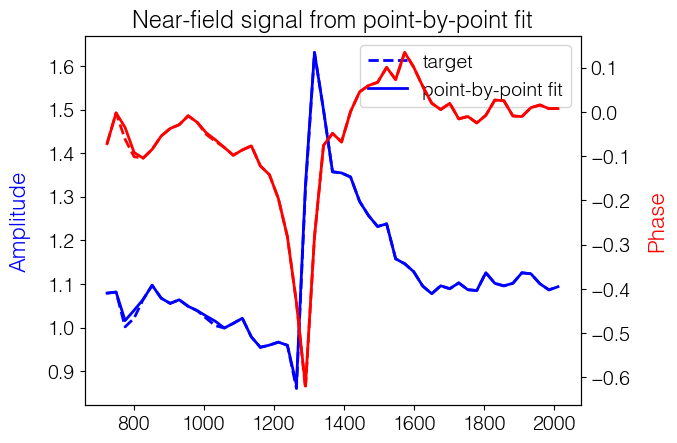

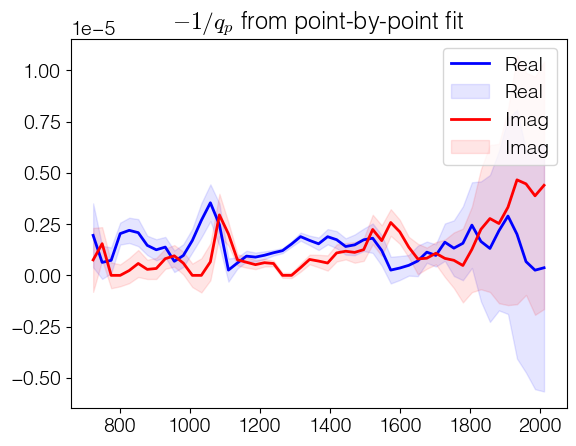

In [21]:
# Perform point-by-point fit of qp for 2D material

# Target signals should be relative to substrate
S_targets = target_spectra[wns2]/target_spectra[sio2]
S_targets_std = target_spectra_std[wns2]/target_spectra[sio2]

qp_guess = .01/P.get_a() # @UPDATE: use whatever initial guess for qp for 2D material.  Start low then go high.
leastsq_kwargs=dict(factor=1000) # @UPDATE: use whatever is best for leastsq
              
PbP_qp_result = EI.Fit_qp_PointByPoint(S_targets,target_fs,
                                       Predictor,epss=MaterialModel.get_epss(),
                                       qp_guess=qp_guess,
                                       exp=1,S_targets_uncertainty=S_targets_std,
                                       **leastsq_kwargs)

Residual before fitting: 7.428294947596504e-11
Elapsed: 0.200
Residual after fitting: 7.291536036024082e-12
Residual before fitting: 1.0980379737948212e-05
Elapsed: 0.071
Residual after fitting: 1.0877755703386862e-05


(0.0, 6e-06)

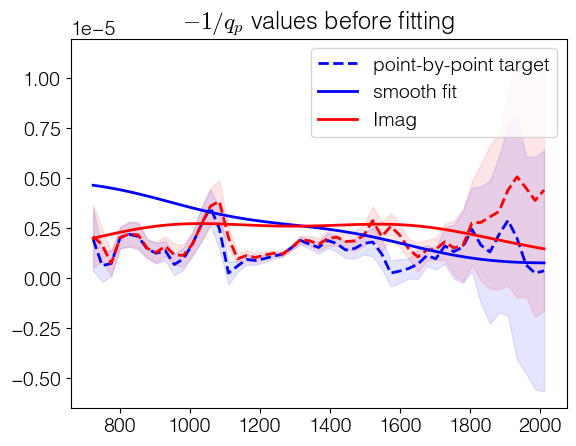

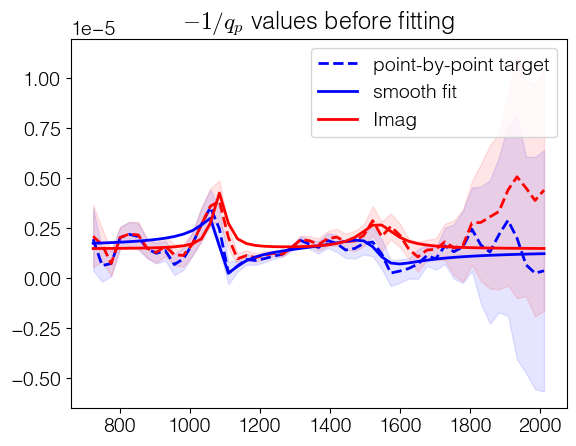

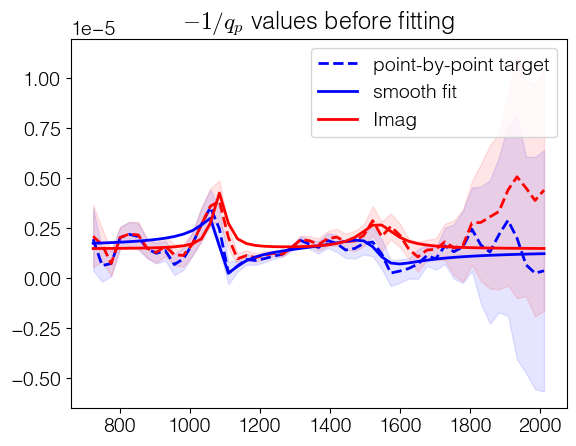

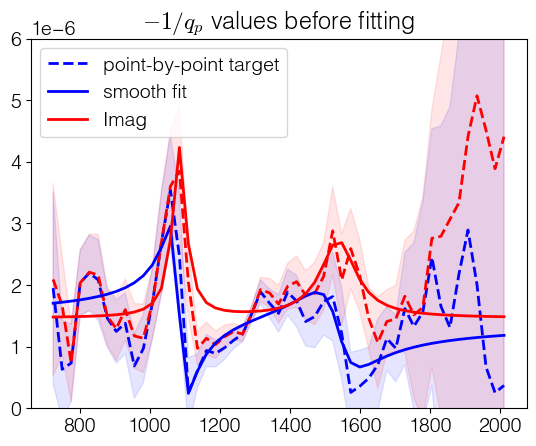

In [22]:
# Find a set of oscillators that best-match the point-by-point qp

leastsq_kwargs = dict(factor=.1,maxfev=10000,ftol=1e-12,xtol=1e-12) # @UPDATE: use whatever helps leastsq do its job
smooth_fit_kwargs = dict(Nosc=2,amp=1*P.get_a(),eps0=1*P.get_a()) # @UPDATE: decide the minimum number of oscillators, and an offset, all have length units
kwargs=copy.copy(leastsq_kwargs)
kwargs.update(smooth_fit_kwargs)

reset_MaterialModel=True
for exp in [2,1]:
    qps_smooth = EI.Fit_PbP_qp_to_oscillators(qp_target=PbP_qp_result['qp_predicted'],
                                              target_fs=target_fs,
                                                 MaterialModel=MaterialModel,
                                                 reset_MaterialModel=reset_MaterialModel,
                                                 exp=exp,
                                                qpinv_target_uncertainties = PbP_qp_result['Delta_eps2D'],
                                                 **kwargs)
    reset_MaterialModel=False

plt.ylim(0,6e-6)


In [23]:
# @UPDATE: If any of these oscillators are bad or extraneous, can delete any of them here
Nosc = (len(MaterialModel.qp_coarse_params)-2)//3 # Each oscillator is a three-tuple
del_osc = None # @UPDATE: If you want to delete the "m'th" oscillator, put `m` here.
if del_osc is not None:
    assert 1 <= del_osc <= Nosc
    ind = (del_osc-1) + 2 # First two entries are the offset
    for i in range(3): del MaterialModel.qp_coarse_params[ind]

### Global refinement using coarse parameters

Supercycle #1..
Optimizing "qp_coarse" in cycle #1...
Optimizing "qp_coarse" in subcycle #1, exp=0.50...
R=10.00; time elapsed (s) in cycle: 25.77
Optimizing "qp_coarse" in subcycle #2, exp=2.00...
R=9.97; time elapsed (s) in cycle: 24.59
Optimizing "qp_coarse" in cycle #2...
Optimizing "qp_coarse" in subcycle #1, exp=0.50...
R=9.98; time elapsed (s) in cycle: 25.61
Exit criterion 0.001 satisfied...
Time elapsed (s) for optimization: 75.96686172485352


(-2.0, 4.0)

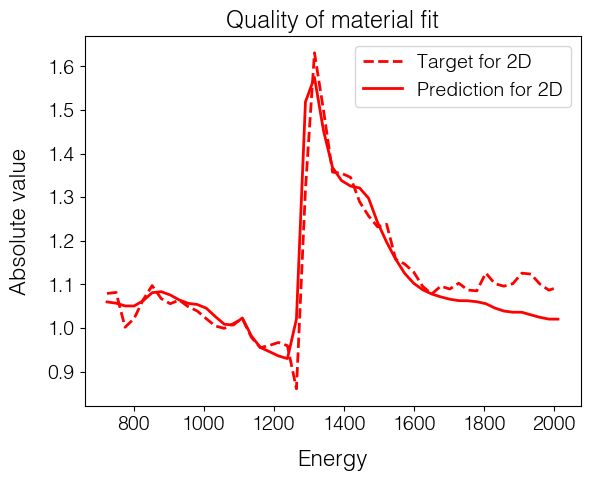

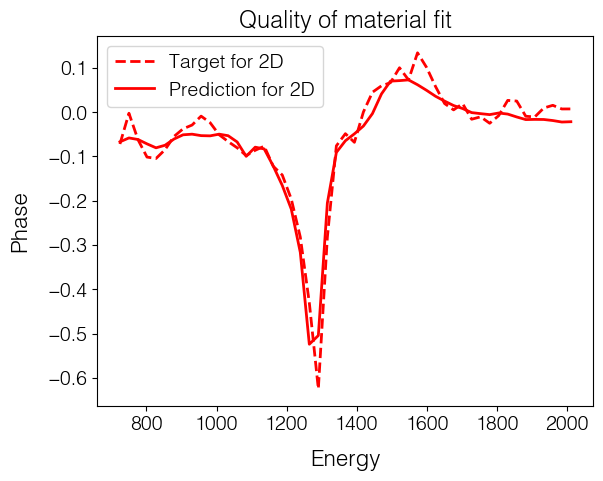

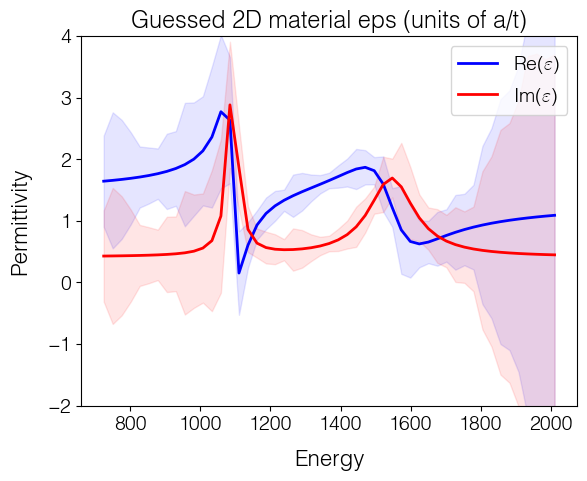

In [24]:
# Choose WNS2 relative to SiO2 as our target
S_targets = target_spectra[wns2]/target_spectra[sio2]
S_targets_std = target_spectra_std[wns2]

# Update the Predictor's normalization signal accordingly
MaterialModel.additional_normalization = S_SiO2_pred # Now predictions will be relative to the predicted SiO2 spectrum

#----- Run the optimization
#@UPDATE: Choose whatever gives the best result
Nsupercycles=1 # Make this nonzero to actually run cycles of optimization, otherwise just plot the prediction
factor=100
randomization=1e-2
optimize_coarse = True
optimize_fine = False # Probably best to keep fine oscillators disabled for 2D material, otherwise we're likely to over-fit the noise

for i in range(Nsupercycles):
    print('Supercycle #%i..'%(i+1))
    
    if optimize_coarse:
        MaterialModel.optimize_qp_coarse(S_targets,S_targets_std,
                                         exp_start=0.5,exp_stop=2,
                                         Nsubcycles=2,Ncycles=2,
                                         factor=factor,full_output=False,xtol=1e-8,ftol=1e-8,
                                          randomization=randomization,
                                         maxfev=100)

    #--- Disable the fine optimization if we want 2D material properties to vary smoothly with frequency (no over-fitting)

    if optimize_fine:
        MaterialModel.optimize_qp_fine(S_targets,S_targets_std,
                                         exp_start=0.5,exp_stop=2,
                                         Nsubcycles=2,Ncycles=2,
                                         factor=1,full_output=False,xtol=1e-8,ftol=1e-8,
                                          randomization=0,maxfev=100)

#---- Plot the prediction
S_WNS2_pred = MaterialModel.predict(qps_enabled=True)

plt.figure()
plt.title('Quality of material fit')
#plt.plot(target_fs,np.abs(target_spectra[sio2]),ls='--',color='b',label='Target for substrate')
#plt.plot(target_fs,np.abs(S_SiO2_pred),ls='-',color='b',label='Prediction for substrate')
plt.plot(target_fs,np.abs(S_targets),ls='--',color='r',label='Target for 2D')
plt.plot(target_fs,np.abs(S_WNS2_pred),ls='-',color='r',label='Prediction for 2D')
plt.ylabel('Absolute value')
plt.xlabel('Energy')
plt.legend()

plt.figure()
plt.title('Quality of material fit')
#plt.plot(target_fs,np.unwrap(np.angle(target_spectra[sio2])),ls='--',color='b',label='Target for substrate')
#plt.plot(target_fs,np.unwrap(np.angle(S_SiO2_pred)),ls='-',color='b',label='Prediction for substrate')
plt.plot(target_fs,np.unwrap(np.angle(S_targets)),ls='--',color='r',label='Target for 2D')
plt.plot(target_fs,np.unwrap(np.angle(S_WNS2_pred)),ls='-',color='r',label='Prediction for 2D')
plt.ylabel('Phase')
plt.xlabel('Energy')
plt.legend()

#---- Plot 2D permittivity and estimated error

experimental_uncertainty = 0.02 # Add an additional relative uncertainty on top of that derived from standard deviation
pred_dev = np.abs(S_WNS2_pred-S_targets)
error = np.sqrt(pred_dev**2+S_targets_std**2) + experimental_uncertainty
deps,dqp = MaterialModel.estimate_error(error,offset=.01)
deps2D_rel = 2*np.abs(dqp/P.get_a()/MaterialModel.get_qps()**2)

plt.figure()
eps2D_rel = -2*1/(P.get_a()*MaterialModel.get_qps())
plt.title('Guessed 2D material eps (units of a/t)')
plt.plot(MaterialModel.freqs,eps2D_rel.real,label=r'Re($\varepsilon$)',color='b')
plt.fill_between(MaterialModel.freqs,
                 eps2D_rel.real+deps2D_rel/2,
                 eps2D_rel.real-deps2D_rel/2,
                 color='b',alpha=.1)
plt.plot(MaterialModel.freqs,eps2D_rel.imag,label=r'Im($\varepsilon$)',color='r')
plt.fill_between(MaterialModel.freqs,
                 eps2D_rel.imag+deps2D_rel/2,
                 eps2D_rel.imag-deps2D_rel/2,
                 color='r',alpha=.1)
plt.legend()
plt.ylabel('Permittivity')
plt.xlabel('Energy')

plt.ylim(-2,4)

### Store MaterialModel parameters

In [25]:
material_params = MaterialModel.get_params()

### Load MaterialModel parameters

In [26]:
MaterialModel.set_params(material_params)

### Plot inferred permittivity of 2D material

Text(0.5, 0, 'Frequency (cm$^{-1}$)')

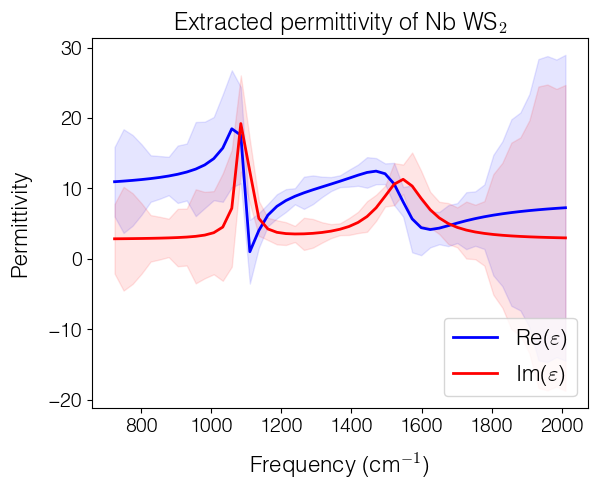

In [27]:
# Convert eps2D to bulk permittivity of thin layer using ratio of film thickness `t` and tip radius `a`
t_div_a = 3/20 # 3 nm divided by 20 nm tip radius

eps2D = eps2D_rel/t_div_a
deps2D = deps2D_rel/t_div_a

plt.figure()
plt.title(r'Extracted permittivity of Nb WS$_2$')
plt.plot(MaterialModel.freqs,eps2D.real,label=r'Re($\varepsilon$)',color='b')
plt.fill_between(MaterialModel.freqs,
                 eps2D.real+deps2D/2,
                 eps2D.real-deps2D/2,
                 color='b',alpha=.1)
plt.plot(MaterialModel.freqs,eps2D.imag,label=r'Im($\varepsilon$)',color='r')
plt.fill_between(MaterialModel.freqs,
                 eps2D.imag+deps2D/2,
                 eps2D.imag-deps2D/2,
                 color='r',alpha=.1)
plt.legend(fontsize=16,loc='lower right')
plt.ylabel('Permittivity')
plt.xlabel(r'Frequency (cm$^{-1}$)')

#plt.ylim(-100,100)

### Interpret an oscillator from the 2D material fit as a Drude

In [28]:
eps_inf_params_2D = MaterialModel.qp_coarse_params[:2]
m_osc_drude = 1 # Suppose the first oscillator is a Drude
ind = (m_osc_drude-1) + 2
Drude_params_2D = MaterialModel.qp_coarse_params[ind:ind+3]

amp,f0,gamma = Drude_params_2D
t_div_a = 3/40 # 2D film thickness relative to tip radius
wp_pred = np.sqrt(2*amp*np.abs(f0)*np.abs(gamma)/t_div_a/P.get_a()) # This formula is easily derived
eps_inf_pred = (eps_inf_params_2D[0]+1j*eps_inf_params_2D[1]) / t_div_a / P.get_a()

print('Center frequency of Drude (should be small, or this oscillator is no Drude after all!): %1.2f cm-1'%f0)
print('Predicted eps_infinity of 2D material (from fitting): %1.2f'%eps_inf_pred)
print('Predicted plasma frequency of 2D material (from fitting): %1.2f cm-1'%wp_pred)
print('Predicted screened plasma frequency of 2D material (from fitting): %1.2f cm-1'% (wp_pred/np.sqrt(eps_inf_pred)) )

Center frequency of Drude (should be small, or this oscillator is no Drude after all!): 1092.32 cm-1
Predicted eps_infinity of 2D material (from fitting): 8.74
Predicted plasma frequency of 2D material (from fitting): 1026.26 cm-1
Predicted screened plasma frequency of 2D material (from fitting): 335.20 cm-1


# Load/Save Material model

## Save Material model

In [ ]:
save=False # Careful, do not overwrite a Material model carefully optimized!

if save:
    filename = 'MaterialModel_(%s).pickle'%os.path.basename(linescan_name)
    with open(filename,'wb') as f:
        pickle.dump(MaterialModel,f)
    print('Material model saved as "%s"!'%filename)

## Load material model

In [ ]:
load=True

if load:
    filename = 'MaterialModel_(%s).pickle'%os.path.basename(linescan_name)
    with open(filename,'rb') as f:
        MaterialModel = pickle.load(f)
    print('Material model loaded from "%s"!'%filename)

    #---- Get reference to Probe
    P = MaterialModel.Predictor.EncodedEigenfields.get_probe()
    
    #---- Update optimized 2D parameters
    Offset_params_2D = MaterialModel.qp_coarse_params[:2]
    Drude_params_2D = MaterialModel.qp_coarse_params[2:2+3]
    Osc_params_2D =MaterialModel.qp_coarse_params[2+3:2+3+3]

# Plot final fit results

In [ ]:
spectra_norm_pred = {}
MaterialModel.additional_normalization = None

# Predict all our gold-normalized spectra with final optimized material model
spectra_norm_pred[sio2] = MaterialModel.predict(qps_enabled=False)
spectra_norm_pred[sio2] = AWA(spectra_norm_pred[sio2],axes=[MaterialModel.freqs])

spectra_norm_pred[wns2] = MaterialModel.predict(qps_enabled=True)
spectra_norm_pred[wns2] = AWA(spectra_norm_pred[wns2],axes=[MaterialModel.freqs])

In [ ]:
f1=plt.figure()
ax11=plt.gca()
ax12=plt.twinx()

f2=plt.figure()
ax21=plt.gca()
ax22=plt.twinx()

from common.plotting import bluered_colors
cs = bluered_colors(len(target_materials))

ls_mat={}
ls_descrip1={}
ls_descrip2={}
for i,mat in enumerate(target_materials):

    S = spectra_norm[mat]
    std = spectra_std_norm[mat]
    S_pred = spectra_norm_pred[mat] / target_phase_corrections[mat]
    c=next(cs)

    plt.sca(ax11)
    l1,=np.abs(S).plot(color=c)
    plt.fill_between(S.axes[0],np.abs(S)+std/2,np.abs(S)-std/2,color=c,alpha=.3)
    l3,=np.abs(S_pred).plot(marker='x',ms=5,ls='',color=c)
    plt.sca(ax12)
    l2,=np.imag(S).plot(color=c,ls='--')
    np.imag(S_pred).plot(marker='x',ms=5,ls='',color=c)

    ls_mat[mat]=l1
    if i==0:
        ls_descrip1['Reflectivity'] = l1
        ls_descrip1['Absorption'] = l2
        ls_descrip1['Fit'] = l3
    
    plt.sca(ax21)
    l1,=np.abs(S).plot(color=c)
    plt.fill_between(S.axes[0],np.abs(S)+std/2,np.abs(S)-std/2,color=c,alpha=.3)
    np.abs(S_pred).plot(marker='x',ms=5,ls='',color=c)
    plt.sca(ax22)
    l2,=plt.plot(S.axes[0],np.unwrap(np.angle(S)),
             color=c,ls='--')
    plt.plot(S_pred.axes[0], np.unwrap(np.angle(S_pred)),
             marker='x',ms=5,ls='',color=c)

    ls_mat[mat]=l1
    if i==0:
        ls_descrip2['Abs(S)'] = l1
        ls_descrip2['Angle(S)'] = l2
    
plt.sca(ax11)
plt.legend(ls_mat.values(),ls_mat.keys(),loc='upper right')
plt.ylabel('Reflectivity')
plt.xlabel('Frequency (cm$^{-1}$)')
plt.sca(ax12)
plt.legend(ls_descrip1.values(),ls_descrip1.keys(),loc='center right')
plt.ylabel('Absorption',rotation=270,labelpad=20)

plt.sca(ax21)
plt.legend(ls_mat.values(),ls_mat.keys(),loc='upper right')
plt.ylabel('Abs(S)')
plt.xlabel('Frequency (cm$^{-1}$)')
plt.sca(ax22)
plt.legend(ls_descrip2.values(),ls_descrip2.keys(),loc='center right')
plt.ylabel('Angle(S) [rad.]',rotation=270,labelpad=20)

    

# Optional: Prepare and evaluate Predictor from scratch

In [ ]:
reload(PCE)

probe_name = 'Hyperboloid_a=20nm_taper=21_L=23microns_Nnodes=244'
P = PCE.load(probe_name,PCE.Probe)
P.set_name(probe_name)
a = P.get_a()

reload(PS)
ProbeGapSpectroscopy = PCE.load(P, PS.ProbeGapSpectroscopyParallel, overwrite_probe=True)

Nmodes_classify=50
ProbeGapSpectroscopy(Nmodes=Nmodes_classify,reversed=True,by_rho=True,debug=False)
eigenrhos = ProbeGapSpectroscopy.get_eigenrhos_AWA(Nmodes=Nmodes_classify)
eigencharges = ProbeGapSpectroscopy.get_eigencharges_AWA()

plt.title('If poles are dispersing smoothly, spectroscopy is good!')
ProbeGapSpectroscopy.plot_eigenrhos(Nmodes=20)

In [ ]:
# Maybe we did some calculations and made forward progress on the Probe spectroscopy, so save it.
PCE.save(ProbeGapSpectroscopy,overwrite=True)

## Compute Encoded Eigenvalues if necessary

In [ ]:
reload(PS)
recompute_EE = False
try:
    if recompute_EE: raise FileNotFoundError
    EE = PCE.load(P,PS.EncodedEigenfields)
except FileNotFoundError:

    # The eigenfields at this gap field will be used as basis for calculations. 
    # Pick something between min and max gap spectroscopy coordinates
    gap0 = P.get_a()
    q0 = 1/P.get_a()
    kappa_max = 20*q0
    EE = PS.EncodedEigenfields(ProbeGapSpectroscopy,gap0=gap0, Nmodes=20,
                                kappa_min=None, kappa_max=kappa_max,
                                Nkappas=244*4, qquadrature=PCE.numrec.GL)
    EE.build_Rmat2D_library(qps=np.logspace(-3, 2, 100)*q0 )
    PCE.save(EE,overwrite=True)

## Validate encoded eigenvalues as a predictor for spectra

In [ ]:
validate_EE=True

if validate_EE:
    
    # Validate EncodedEigenfields against calculations with the Probe itself (latter should be best accuracy but slowest)
    def get_beta(freq,q):
    
        return M.SiO2_300nm.reflection_p(freq,q*1e4)

    freqs_test = np.linspace(700,1400,200)
    kwargs= dict(freqs_wn=freqs_test,
                 a_nm=30,amplitude_nm=50,demod_order=5,Ngaps=24,gapmin_nm=1,L_cm=24e-4,
                 rp=get_beta,rp_norm=M.Au.reflection_p,norm_single_freq=True)
    
    # Compute spectrum using Probe object (expensive, most flexible)   
    test_spectrum_P = P.getNormalizedSignal(**kwargs)
    
    # Compute spectrum using Encoded eigenfields that uses basis eigenfields only (cheap, still flexible)  
    test_spectrum_EE = EE.getNormalizedSignal(**kwargs)
    
    # Compute spectrum using analytic poles and residues (cheapest, but least flexible)
    IE = PS.InvertibleEigenfields(ProbeGapSpectroscopy, Nmodes=20,
                                interpolation='cubic')
    
    epss = M.SiO2_300nm.epsilon(freqs_test) 
    beta = (epss-1)/(epss+1)
    beta_norm=1
    
    test_spectrum_IE = IE.getNormalizedSignal(freqs_wn=freqs_test,
                                     a_nm=30,amplitude_nm=50,demod_order=5,Ngaps=24,gapmin_nm=1,L_cm=24e-4,
                                     beta=beta,beta_norm=[beta_norm]*len(beta))
    
    #--- Plot their comparison, they should all agree about SiO2 spectrum
    np.abs(test_spectrum_P['Sn_norm'][3]).plot(label = 'raw Sommerfeld calculation')
    np.abs(test_spectrum_EE['Sn_norm'][3]).plot( label = 'Encoded eigenfields')
    plt.plot(freqs_test,np.abs(test_spectrum_IE['Sn_norm'][3]),label='analytic eigenvalues')
    plt.legend()

## Build a predictor that can allow least-squares fitting

In [ ]:
reload(EI)
Predictor = EI.EncodedEigenfieldsPredictor(EE,
                                         zmin=P.get_a()/10, A=2*P.get_a(), Nts=24,
                                         harmonic=3,
                                         qp_ref=1e8*1/P.get_a(),
                                         eps_ref=1e8,
                                          Nmodes=15) # Reference material will be high permittivity, with no 2D material atop (qp --> infinity)

#--- Test that predictor can reasonably predict near-field spectra

freqs_test = np.linspace(700,1500,100)
epss_test = M.SiO2_300nm.epsilon(freqs_test)
qp_test = 1e8*1/P.get_a() # qp --> infinity
Ss_test = [Predictor(qp=qp_test,eps=eps) for eps in epss_test]
Ss_test = AWA(Ss_test,axes=[freqs_test],axis_names=['Frequency (cm-1)'])

np.abs(Ss_test).plot(label='Reflectance')
np.imag(Ss_test).plot(label='Absorption')
plt.legend()